# Introduction


### Accessing the Data

In [156]:
# Includuing all additional imports
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import numpy as np
import itertools

train = pd.read_csv("https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv")
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


*Including all additional imports*

## Exploring the Data
### Preliminary Visualizations


In [157]:
# Data modification
train_viz = train.copy()
loan_status_recode = {0: 'Paid in Full', 1: 'Defaulted'}
train_viz['loan_repayment'] = train_viz['loan_status'].map(loan_status_recode)
train_viz.loc[train_viz["person_age"] >= 100, "person_age"] = None
train_viz = train_viz.dropna()

# Subsetting data by loan status
default = train_viz[train_viz['loan_status'] == 1].copy().dropna()
repaid = train_viz[train_viz['loan_status'] == 0].copy().dropna()

*Modifying training data for visualization*

In [158]:
# Creating linear regression models and calculating R^2 values
## Default
c1 = np.polyfit(default['loan_amnt'], default['person_income'], 1)
p1 = np.polyval(c1, default['loan_amnt'])
r1 = default['person_income'] - p1
ssr1 = np.sum(r1**2)
sst1 = np.sum((default['person_income'] - np.mean(default['loan_amnt']))**2)
rs1 = 1 - (ssr1 / sst1)

## Repaid
c2 = np.polyfit(repaid['loan_amnt'], repaid['person_income'], 1)
p2 = np.polyval(c2, repaid['loan_amnt'])
r2 = repaid['person_income'] - p2
ssr2 = np.sum(r2**2)
sst2 = np.sum((repaid['person_income'] - np.mean(repaid['loan_amnt']))**2)
rs2 = 1 - (ssr2 / sst2)

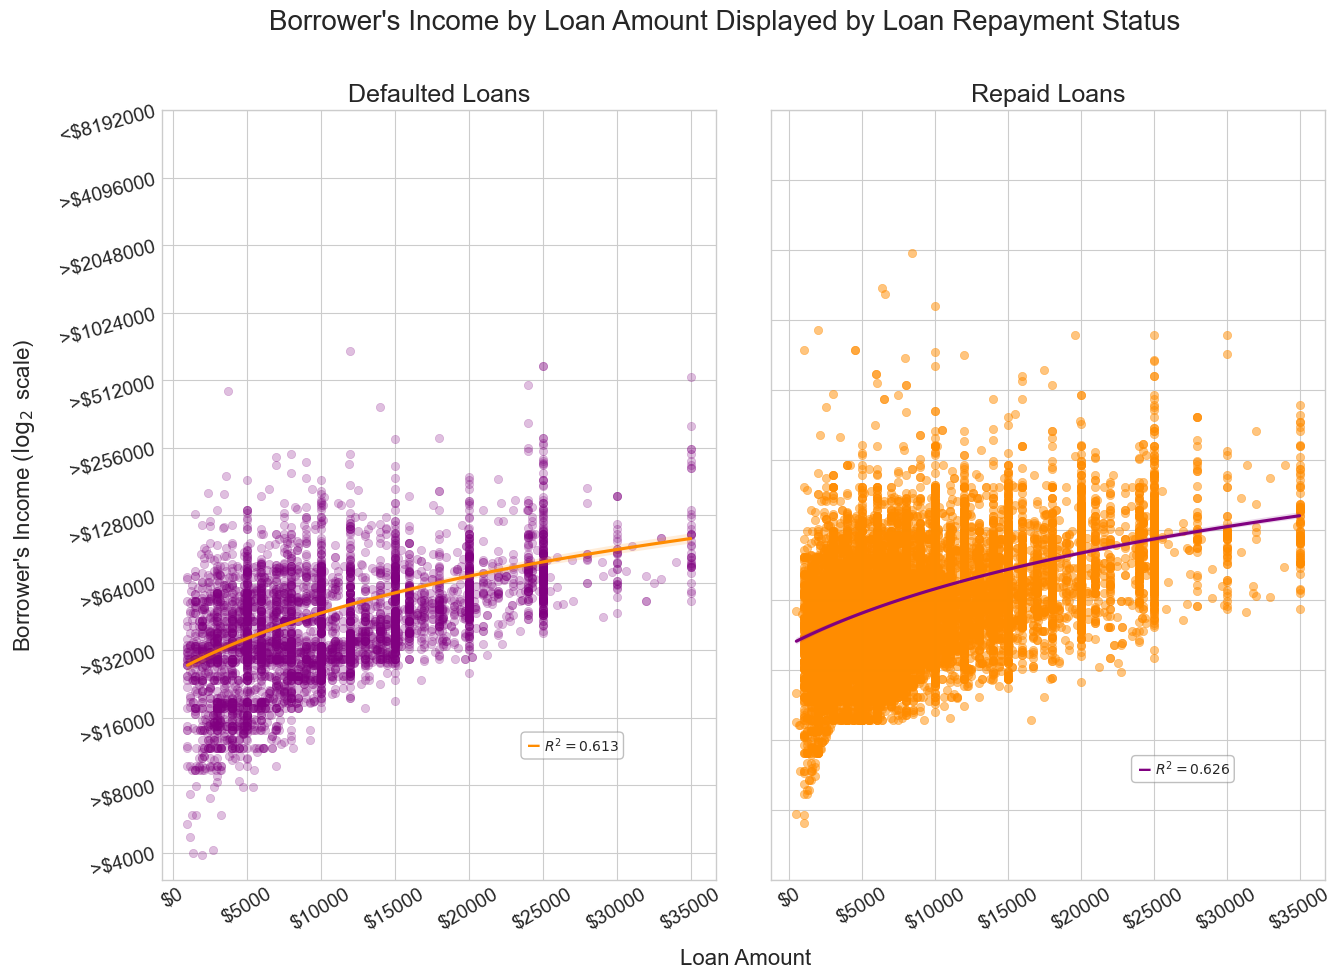

In [159]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Scatterplot and regression line for borrower income by loan amount of defaulted loans
ax[0] = sns.scatterplot(data = default, x = 'loan_amnt', y = 'person_income', color = 'purple', edgecolor = 'purple', alpha = 0.25, ax = ax[0])
sns.regplot(data = default, x = 'loan_amnt', y = 'person_income', scatter = False, line_kws={'color': 'darkorange'}, ax = ax[0])
ax[0].set_yscale('log', base = 2)
ax[0].set_xlabel('')
ax[0].set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
ax[0].set_xticklabels(['$0', '$5000', '$10000', '$15000', '$20000', '$25000', '$30000', '$35000'], rotation = 30, fontsize = 14)
ax[0].set_ylabel(f'Borrower\'s Income ($\log_2$ scale)', fontsize = 16, labelpad = 15)
ax[0].set_yticks([2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21, 2**22, 2**23])
ax[0].set_yticklabels([">$4000", ">$8000", ">$16000", ">$32000", ">$64000", ">$128000", ">$256000", ">$512000", ">$1024000", ">$2048000", ">$4096000", "<$8192000"], rotation = 15, fontsize = 14)
ax[0].set_title('Defaulted Loans', fontsize = 18)
ax[0].text(27000, 12288, f'     $R^2 = {rs1:.3f}$', ha = 'center', va = 'center', fontsize = 10, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'gray', boxstyle = 'round,pad=0.3'))
ax[0].text(24000, 12288, '\u2013', color='darkorange', ha='left', va='center', fontsize=15, fontweight='bold')

# Scatterplot and regression line for borrower income by loan amount of repaid loans
ax[1] = sns.scatterplot(data = repaid, x = 'loan_amnt', y = 'person_income', color = 'darkorange', edgecolor = 'darkorange', alpha = 0.5, ax = ax[1])
sns.regplot(data = repaid, x = 'loan_amnt', y = 'person_income', scatter = False, line_kws={'color': 'purple'}, ax = ax[1])
ax[1].set_yscale('log', base = 2)
ax[1].set_xlabel('')
ax[1].set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
ax[1].set_xticklabels(['$0', '$5000', '$10000', '$15000', '$20000', '$25000', '$30000', '$35000'], rotation=30, fontsize = 14)
ax[1].set_ylabel('')
ax[1].set_yticks([2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21, 2**22, 2**23])
ax[1].set_yticklabels(["", "", "", "", "", "", "", "", "", "", "", ""], rotation = 15)
ax[1].set_title('Repaid Loans', fontsize = 18)
ax[1].text(27000, 12288, f'     $R^2 = {rs2:.3f}$', ha = 'center', va = 'center', fontsize = 10, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'gray', boxstyle = 'round,pad=0.3'))
ax[1].text(24000, 12288, '\u2013', color='purple', ha='left', va='center', fontsize=15, fontweight='bold')

fig.suptitle('Borrower\'s Income by Loan Amount Displayed by Loan Repayment Status', fontsize = 20)
fig.text(0.47, 0.025, 'Loan Amount', fontsize = 16)
plt.subplots_adjust(wspace=0.1)

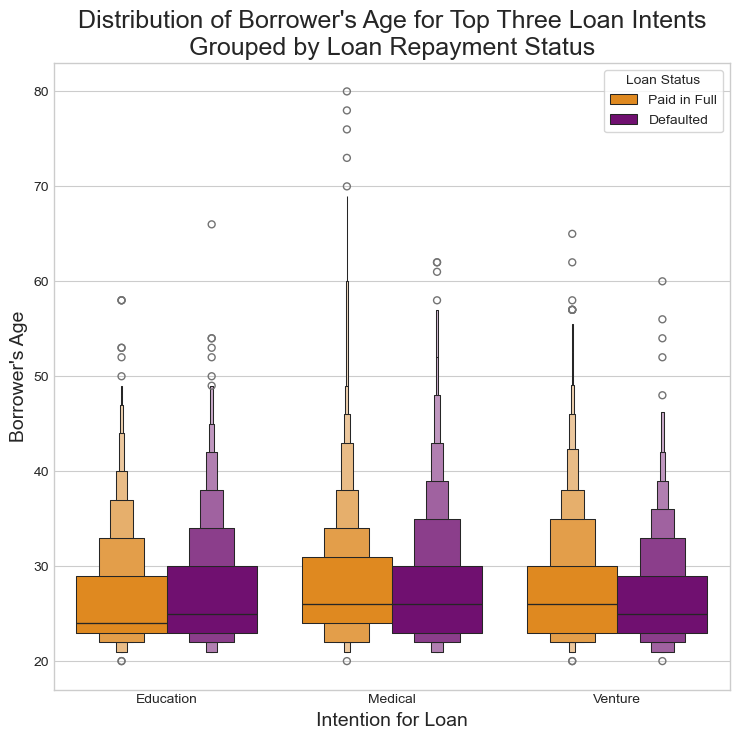

In [160]:
# Subsetting data to the three most common loan intents
common_loan_intents = train_viz.copy()
common_loan_intents = train_viz[train_viz["loan_intent"].isin(["EDUCATION", "MEDICAL", "VENTURE"])].copy()
common_loan_intents.dropna()

# Creating Boxen Plot
fig, ax = plt.subplots(1, 1, figsize = (7.5, 7.5))
plt.style.use('seaborn-v0_8-whitegrid')

p = sns.boxenplot(common_loan_intents, x = "loan_intent", y = "person_age", hue = "loan_repayment", palette = ["darkorange", "purple"])
p.set_xlabel("Intention for Loan", fontsize = 14)
p.set_ylabel("Borrower\'s Age", fontsize = 14)
p.set_xticks(["EDUCATION", "MEDICAL", "VENTURE"])
p.set_xticklabels(["Education", "Medical", "Venture"])
p.legend(title = "Loan Status", frameon = True)
p.set_title("Distribution of Borrower\'s Age for Top Three Loan Intents\nGrouped by Loan Repayment Status", fontsize = 18)
plt.tight_layout()

*Code Description*

Analysis of the above figures.

### Table of General Summary Statistics

In [161]:
# Summary Statistics

# Helper method to calculate coefficient of variation (%)
def cv(col):
    return (col.std() / col.mean()) * 100

# Creating a table grouped by penguin species and sex, showing general summary stats for several quantitative variables
sum_stats = train_viz.rename(columns = {"loan_repayment": "Loan Repayment", "loan_amnt": "Loan Amount", "person_income": "Borrower\'s Income", "loan_intent": "Loan Intent", "person_age": "Borrower\'s Age", "loan_percent_income": "Loan Percent Income"}).copy()
sum_stats = sum_stats.groupby(["Loan Repayment", "Loan Intent"]).aggregate({"Loan Amount" : ["mean", "std", cv], 
                                                             "Borrower\'s Income" : ["mean", "std", cv], "Loan Percent Income": ["mean", "std", cv], 
                                                             "Borrower\'s Age": ["mean", "std", cv]})
sum_stats = sum_stats.rename(columns = {'mean': 'Mean', 'std': 'STD', 'cv': 'CV (%)'})
sum_stats = sum_stats.round(2)
sum_stats

Loan Amount                  \
                                        Mean      STD CV (%)   
Loan Repayment Loan Intent                                     
Defaulted      DEBTCONSOLIDATION    11283.45  7357.29  65.20   
               EDUCATION            10912.82  6979.08  63.95   
               HOMEIMPROVEMENT      10035.04  7324.85  72.99   
               MEDICAL              11438.49  7190.60  62.86   
               PERSONAL             10459.89  6884.86  65.82   
               VENTURE              11115.68  6695.34  60.23   
Paid in Full   DEBTCONSOLIDATION     9050.14  5810.33  64.20   
               EDUCATION             9206.44  6010.44  65.29   
               HOMEIMPROVEMENT      10518.51  6398.11  60.83   
               MEDICAL               8570.88  5645.54  65.87   
               PERSONAL              9441.60  6133.81  64.97   
               VENTURE               9307.47  6064.40  65.16   

                                 Borrower's Income                   \
                                              Mean       STD CV (%)   
Loan Repayment Loan Intent                                            
Defaulted      DEBTCONSOLIDATION          54553.15  37624.33  68.97   
               EDUCATION                  47283.67  30264.34  64.01   
               HOMEIMPROVEMENT            49794.13  33062.93  66.40   
               MEDICAL                    52477.12  44092.21  84.02   
               PERSONAL                   46965.14  39080.81  83.21   
               VENTURE                    44439.34  27743.83  62.43   
Paid in Full   DEBTCONSOLIDATION          72388.92  61644.36  85.16   
               EDUCATION                  67866.15  41045.51  60.48   
               HOMEIMPROVEMENT            82499.92  50452.00  61.15   
               MEDICAL                    65116.70  51476.94  79.05   
               PERSONAL                   72343.94  54121.45  74.81   
               VENTURE                    70493.68  58762.60  83.36   

                                 Loan Percent Income               \
                                                Mean   STD CV (%)   
Loan Repayment Loan Intent                                          
Defaulted      DEBTCONSOLIDATION                0.24  0.13  57.00   
               EDUCATION                        0.26  0.13  51.90   
               HOMEIMPROVEMENT                  0.22  0.13  57.24   
               MEDICAL                          0.24  0.13  54.74   
               PERSONAL                         0.25  0.13  51.99   
               VENTURE                          0.28  0.13  47.39   
Paid in Full   DEBTCONSOLIDATION                0.14  0.08  58.11   
               EDUCATION                        0.15  0.09  57.71   
               HOMEIMPROVEMENT                  0.14  0.09  61.15   
               MEDICAL                          0.15  0.08  56.46   
               PERSONAL                         0.15  0.09  57.83   
               VENTURE                          0.15  0.09  59.45   

                                 Borrower's Age               
                                           Mean   STD CV (%)  
Loan Repayment Loan Intent                                    
Defaulted      DEBTCONSOLIDATION          27.76  6.52  23.49  
               EDUCATION                  27.09  6.10  22.50  
               HOMEIMPROVEMENT            27.62  6.04  21.86  
               MEDICAL                    27.70  6.31  22.78  
               PERSONAL                   27.24  6.09  22.37  
               VENTURE                    26.74  5.45  20.38  
Paid in Full   DEBTCONSOLIDATION          27.54  5.66  20.56  
               EDUCATION                  26.43  5.49  20.79  
               HOMEIMPROVEMENT            29.47  5.48  18.60  
               MEDICAL                    27.96  6.17  22.07  
               PERSONAL                   28.49  7.42  26.03  
               VENTURE                    27.74  5.98  21.57

*In creating the table above, I looked up how to calculate the CV for each of the columns to more easily interpret the STD and created the helper method*

Analysis of the summary statistics table.

# Model Construction
## Feature Selection


In [162]:
# Modifying the training data
X = train.drop(["loan_status", "loan_grade"], axis = 1, errors = "ignore")
y = train["loan_status"]

# Creating one-hot encodings for qualitative variables
X = pd.get_dummies(X, drop_first = True)

# Removing NAs from data while maintaining alignment
clean = pd.concat([X, y], axis = 1)
clean = clean.dropna()
X_train = clean.drop("loan_status", axis = 1, errors = "ignore").copy()
y_train = clean["loan_status"].copy()

# Identifying quantitative and qualitative variables in the data
quant_vars = [
              "person_age", 
              "person_income", 
              "person_emp_length", 
              "loan_amnt", 
              "loan_int_rate", 
              "loan_percent_income", 
              "cb_person_cred_hist_length"
            ]
qual_vars = [
              "person_home_ownership_OTHER",
              "person_home_ownership_OWN",
              "person_home_ownership_RENT",
              "loan_intent_EDUCATION",
              "loan_intent_HOMEIMPROVEMENT",
              "loan_intent_MEDICAL",
              "loan_intent_PERSONAL",
              "loan_intent_VENTURE",
              "cb_person_default_on_file_Y"
            ]

# Combination of selected quant and qual variables
cols = quant_vars + qual_vars

# Toggle to run feature selection process
if (False):

  # Iterating through all possible subsets of cols, evaluating a model with each subset, to determine the optimal set of variables to use
  best_vars = []
  best_avg_score = 0

  # Paramters to determine the size of tested subsets
  lower_bound = 5
  upper_bound = 6
  for i in range(lower_bound, upper_bound):
      
      # Iterating through all subsets
      for subset in itertools.combinations(cols, i):
        curr_vars = list(subset)
        # Fitting a model to each subset
        LR = LogisticRegression(random_state = 69)
        LR.fit(X_train[curr_vars], y_train)
        curr_avg_score = cross_val_score(LR, X_train[curr_vars], y_train, cv = 5).mean()
        
        # Update the best average score and the best variables to use for the model
        if (curr_avg_score > best_avg_score):
          best_avg_score = curr_avg_score
          best_vars = curr_vars

best_vars = ['loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_OTHER', 'person_home_ownership_RENT', 'loan_intent_HOMEIMPROVEMENT']
# Initial model
LR = LogisticRegression(random_state = 69)
LR.fit(X_train[best_vars], y_train)
score = LR.score(X_train[best_vars], y_train)
print(score)
w = np.array(LR.coef_[0])

0.8509625878552407


*Code Description*

Analysis of feature selection.

## Creating a Scoring Function



In [163]:
# Function to compute the score for each observation
def lin_score(X, w):
    return np.dot(X, w)

# Computing scores of each training observation and observing confusion matrix
scores = lin_score(X_train[best_vars], w)
LR_pred = LR.predict(X_train[best_vars])
C = confusion_matrix(y_train, LR_pred)
C

array([[17702,   279],
       [ 3135,  1791]])

*Best Vars: ['loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_OTHER', 'person_home_ownership_RENT', 'loan_intent_HOMEIMPROVEMENT']*

Analysis of creating scoring function.

## Choosing a Threshold

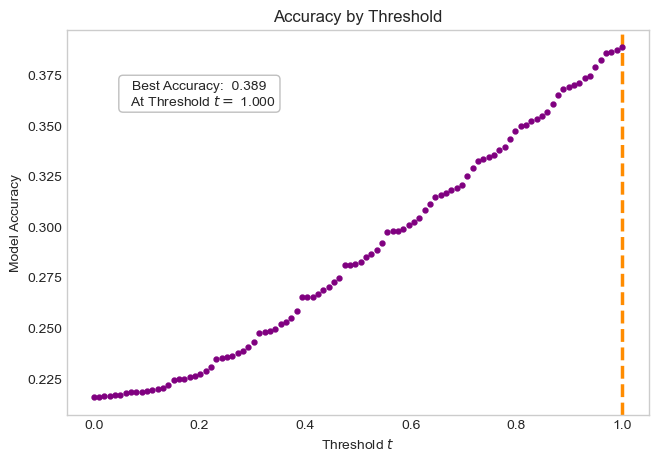

In [164]:
# Threshold selection based on model accuracy
best_accuracy = 0
best_threshold = 0

# Following code is adapted from Prof. Chodrow
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))
for t in np.linspace(0, 1, 100): 
    y_pred = scores >= t
    acc = (y_pred == y_train).mean()
    ax.scatter(t, acc, color = "purple", s = 12.5)
    if acc > best_accuracy: 
        best_accuracy = acc
        best_threshold = t
ax.axvline(best_threshold, linestyle = "--", color = "darkorange", linewidth = 2.5, zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Model Accuracy", title = "Accuracy by Threshold")
ax.text(0.2, 0.360, f"Best Accuracy: {best_accuracy: .3f}\n  At Threshold $t = ${best_threshold: .3f}", ha = "center",
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'grey', boxstyle = 'round,pad=0.3'))
ax.grid(False)

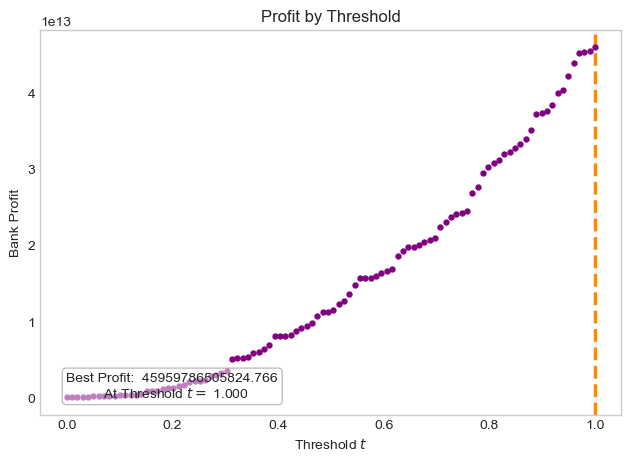

In [165]:
# Threshold selection based on profit for the bank created by the model
best_profit = 0
best_threshold = 0

# Bank profit variable
best_profit = 0

# Following code is adapted from Prof. Chodrow
fig, ax = plt.subplots(1, 1, figsize = (7.5, 5))

for t in np.linspace(0, 1, 100): 
    y_pred = scores >= t
    
    # Temporary profit variables
    profit_gain = 0
    profit_loss = 0
    for i in range(X_train.shape[0]):

        # Determing loan amount and interest rate for each observation
        loan_amnt = X_train.iloc[i]["loan_amnt"]
        loan_int_rate = X_train.iloc[i]["loan_int_rate"]

        # Adding to profit gain on fully repaid loans
        if ((y_pred[i] == 0) & (y_train.iloc[i] == 0)):
            profit_gain += loan_amnt * ((1 + (0.25 * loan_int_rate)) ** 10) - loan_amnt
        
        # Adding to profit loss on defaulted loans
        elif ((y_pred[i] == 0) & (y_train.iloc[i] == 1)):
             profit_loss += loan_amnt * ((1 + (0.25 * loan_int_rate)) ** 3) - (1.7 * loan_amnt)
    
    # Profit with current threshold
    profit = profit_gain + profit_loss
    
    # Ploting profit point and updating variables
    ax.scatter(t, profit, color = "purple", s = 12.5)
    if profit > best_profit: 
        best_profit = profit
        best_threshold = t

# Plot styling
ax.axvline(best_threshold, linestyle = "--", color = "darkorange", linewidth = 2.5, zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Bank Profit", title = "Profit by Threshold")
ax.text(0.2, 7, f"Best Profit: {best_profit: .3f}\n  At Threshold $t = ${best_threshold: .3f}", ha = "center",
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'grey', boxstyle = 'round,pad=0.3'))
ax.grid(False)

*Code Description*

Analysis of choosing a threshold.

# Model Evaluation
## Perspective of the Bank


*Code Description*

Analysis of model evaluation from the perspective of the bank.

## Perspective of the Borrower

*Code Description*

Analysis of model evaluation from the perspective of the borrower.

# Discussion


*During the implementation process of this blog post, I collaborated with __________*